Using device: cuda
Columns: ['timestamp', 'load', 'temperature_2m', 'relativehumidity_2m', 'apparent_temperature', 'shortwave_radiation', 'precipitation', 'wind_speed_10m', 'is_holiday', 'dow', 'hour', 'is_weekend', 'month', 'heat_index', 'lag_1', 'lag_24', 'lag_168', 'roll24', 'roll168']

Date range: 2021-01-08 00:00:00 → 2024-12-31 23:00:00
Total rows: 34896

Train period: 2021-01-15 00:00:00 → 2024-01-01 22:00:00 rows: 25967
Test  period: 2024-01-01 23:00:00 → 2024-12-31 23:00:00 rows: 8761

Num features: 17

Train rows: 23371, Val rows: 2596, Test rows: 8761

Training LightGBM baseline...
Training until validation scores don't improve for 200 rounds
[200]	train's rmse: 217.538	valid's rmse: 183.844
[400]	train's rmse: 114.654	valid's rmse: 101.6
[600]	train's rmse: 98.541	valid's rmse: 92.7718
[800]	train's rmse: 90.3725	valid's rmse: 89.5544
[1000]	train's rmse: 84.6534	valid's rmse: 87.8682
[1200]	train's rmse: 79.9805	valid's rmse: 86.7627
[1400]	train's rmse: 76.0083	valid's rm

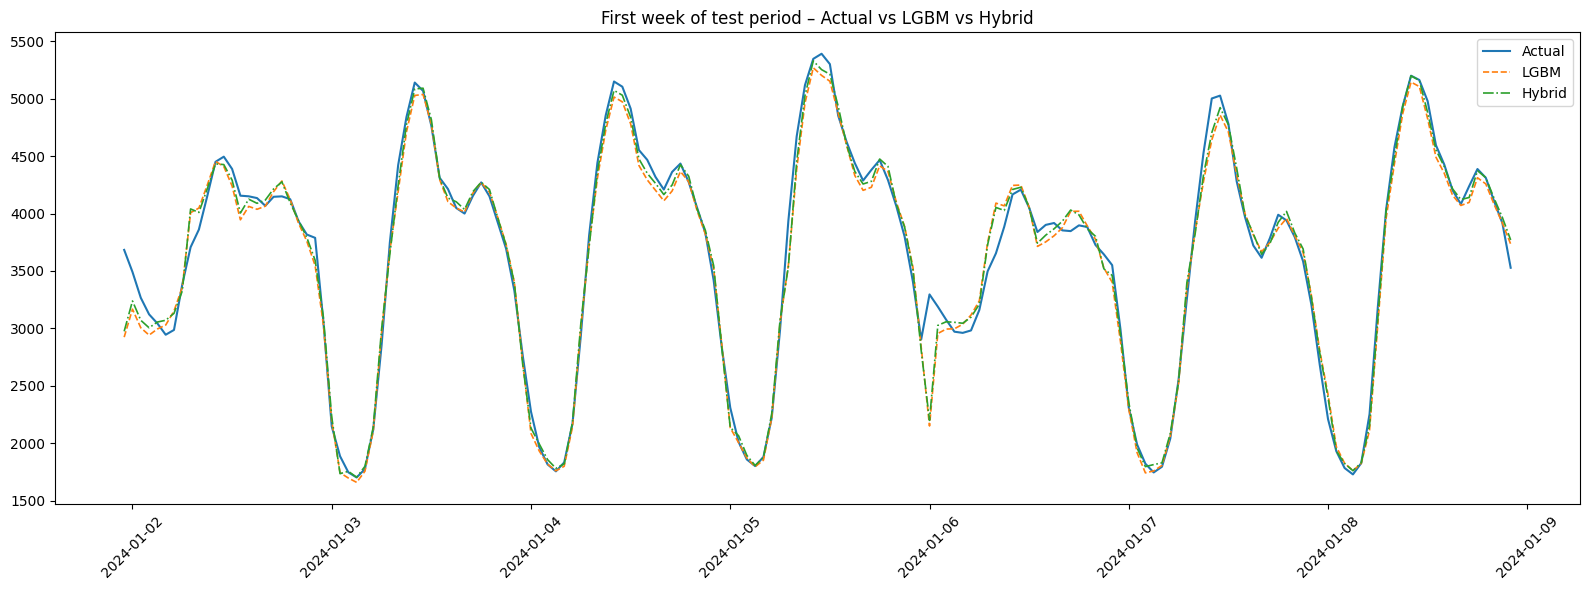


Saved models to forecast_outputs/


In [1]:
# ============================================
# LGBM + Transformer Residual Hybrid for Load Forecasting
# Target: Test MAPE < 2% on 2024
# ============================================

import os
import gc
import math
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime

# LightGBM
import lightgbm as lgb

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# --------------------------------------------
# CONFIG
# --------------------------------------------
DATA_PATH = "/kaggle/input/master-db/master_db.csv"  # change if your file is elsewhere
TIMESTAMP_COL = "timestamp"
TARGET_COL = "load"

# train / test split by timestamp (same as your LGBM logs)
TRAIN_START = "2021-01-15 00:00:00"
TRAIN_END   = "2024-01-01 22:00:00"
TEST_START  = "2024-01-01 23:00:00"
TEST_END    = "2024-12-31 23:00:00"

# LightGBM settings
LGBM_PARAMS = {
    "objective": "regression",
    "metric": "rmse",
    "boosting_type": "gbdt",
    "learning_rate": 0.01,
    "num_leaves": 64,
    "max_depth": -1,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "lambda_l1": 0.0,
    "lambda_l2": 0.0,
    "verbosity": -1,
}

NUM_BOOST_ROUND = 4000
EARLY_STOPPING_ROUNDS = 200

# Transformer settings
SEQ_LEN = 168        # use last 168 hours of residuals (7 days)
BATCH_SIZE = 512
EPOCHS = 25
D_MODEL = 64
NHEAD = 4
NUM_LAYERS = 2
DIM_FEEDFORWARD = 128
DROPOUT = 0.1
LR = 1e-3

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# ============================================
# 1. DATA LOADING
# ============================================
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(
        f"{DATA_PATH} not found. "
        "Change DATA_PATH at the top of the notebook to point to your feature CSV."
    )

df = pd.read_csv(DATA_PATH)

# Ensure timestamp is datetime and sorted
df[TIMESTAMP_COL] = pd.to_datetime(df[TIMESTAMP_COL])
df = df.sort_values(TIMESTAMP_COL).reset_index(drop=True)

print("Columns:", list(df.columns))
print()
print("Date range:", df[TIMESTAMP_COL].min(), "→", df[TIMESTAMP_COL].max())
print("Total rows:", len(df))

# ============================================
# 2. TRAIN / TEST SPLIT
# ============================================
train_mask = (df[TIMESTAMP_COL] >= TRAIN_START) & (df[TIMESTAMP_COL] <= TRAIN_END)
test_mask  = (df[TIMESTAMP_COL] >= TEST_START)  & (df[TIMESTAMP_COL] <= TEST_END)

train_df = df.loc[train_mask].copy()
test_df  = df.loc[test_mask].copy()

print("\nTrain period:", train_df[TIMESTAMP_COL].min(), "→", train_df[TIMESTAMP_COL].max(), "rows:", len(train_df))
print("Test  period:", test_df[TIMESTAMP_COL].min(), "→", test_df[TIMESTAMP_COL].max(), "rows:", len(test_df))

# Features: all non-target, non-timestamp columns
feature_cols = [c for c in df.columns if c not in [TIMESTAMP_COL, TARGET_COL]]
print("\nNum features:", len(feature_cols))

X_train = train_df[feature_cols].values
y_train = train_df[TARGET_COL].values

X_test = test_df[feature_cols].values
y_test = test_df[TARGET_COL].values

# Optional: small validation split from the tail of training set
VAL_FRACTION = 0.1
val_size = int(len(X_train) * VAL_FRACTION)

X_tr, X_val = X_train[:-val_size], X_train[-val_size:]
y_tr, y_val = y_train[:-val_size], y_train[-val_size:]

print(f"\nTrain rows: {len(X_tr)}, Val rows: {len(X_val)}, Test rows: {len(X_test)}")

# ============================================
# 3. LIGHTGBM BASELINE
# ============================================
print("\nTraining LightGBM baseline...")

train_dataset = lgb.Dataset(X_tr, label=y_tr)
valid_dataset = lgb.Dataset(X_val, label=y_val, reference=train_dataset)

lgbm_model = lgb.train(
    LGBM_PARAMS,
    train_dataset,
    num_boost_round=NUM_BOOST_ROUND,
    valid_sets=[train_dataset, valid_dataset],
    valid_names=["train", "valid"],
    callbacks=[
        lgb.early_stopping(EARLY_STOPPING_ROUNDS),
        lgb.log_evaluation(200),
    ],
)

print("\nBest iteration:", lgbm_model.best_iteration)

# Predictions for full train+test
train_df["lgbm_pred"] = lgbm_model.predict(train_df[feature_cols].values, num_iteration=lgbm_model.best_iteration)
test_df["lgbm_pred"]  = lgbm_model.predict(test_df[feature_cols].values, num_iteration=lgbm_model.best_iteration)

# --------------------------------------------
# Metrics
# --------------------------------------------
def rmse(y_true, y_pred):
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

def mape(y_true, y_pred, eps=1e-6):
    denom = np.maximum(np.abs(y_true), eps)
    return float(np.mean(np.abs((y_true - y_pred) / denom)) * 100)

lgbm_rmse_test = rmse(test_df[TARGET_COL].values, test_df["lgbm_pred"].values)
lgbm_mape_test = mape(test_df[TARGET_COL].values, test_df["lgbm_pred"].values)

print("\n================ LIGHTGBM BASELINE ================")
print(f"Test RMSE: {lgbm_rmse_test:,.2f}")
print(f"Test MAPE: {lgbm_mape_test:.2f}%")

# ============================================
# 4. RESIDUAL SERIES FOR TRANSFORMER
# ============================================
# We'll build a single continuous residual series (train + test),
# but only use train part for training the Transformer.

df_all = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)
df_all = df_all.sort_values(TIMESTAMP_COL).reset_index(drop=True)

# Make sure predictions exist everywhere we need them
df_all["lgbm_pred"] = df_all["lgbm_pred"].astype(float)
df_all[TARGET_COL] = df_all[TARGET_COL].astype(float)

df_all["residual"] = df_all[TARGET_COL] - df_all["lgbm_pred"]

# Mark train/test indices within df_all
df_all["is_train"] = df_all[TIMESTAMP_COL].between(TRAIN_START, TRAIN_END, inclusive="both")
df_all["is_test"]  = df_all[TIMESTAMP_COL].between(TEST_START, TEST_END, inclusive="both")

print("\nResidual series ready.")
print("Residual mean:", df_all["residual"].mean(), "std:", df_all["residual"].std())

# Standardize residuals for Transformer
from sklearn.preprocessing import StandardScaler

res_scaler = StandardScaler()
df_all["resid_scaled"] = res_scaler.fit_transform(df_all[["residual"]])

# We will build sequences from the *index* of df_all.
# Only indices where is_train == True will be used as targets for training.


# ============================================
# 5. TRANSFORMER DATASET
# ============================================

class ResidualDataset(Dataset):
    def __init__(self, resid_series, idx_targets, seq_len):
        """
        resid_series : 1D numpy array of scaled residuals (full timeline).
        idx_targets  : indices in resid_series that we want to predict.
        seq_len      : length of input sequence.
        """
        self.resid = resid_series
        self.idx_targets = idx_targets
        self.seq_len = seq_len

    def __len__(self):
        return len(self.idx_targets)

    def __getitem__(self, i):
        t = self.idx_targets[i]
        start = t - self.seq_len
        end = t

        x_seq = self.resid[start:end]      # shape: [seq_len]
        y = self.resid[t]                  # predict next residual at time t

        x_seq = torch.tensor(x_seq, dtype=torch.float32).unsqueeze(-1)  # [seq_len, 1]
        y = torch.tensor(y, dtype=torch.float32)

        return x_seq, y

# Compute valid indices for Transformer training: must have seq_len history AND be train
resid_all = df_all["resid_scaled"].values
n_all = len(df_all)

idx_train_targets = []
for t in range(SEQ_LEN, n_all):
    if df_all.loc[t, "is_train"]:
        idx_train_targets.append(t)

# We'll also create target indices for test (for evaluation)
idx_test_targets = []
for t in range(SEQ_LEN, n_all):
    if df_all.loc[t, "is_test"]:
        idx_test_targets.append(t)

print(f"\nTransformer train samples: {len(idx_train_targets)}")
print(f"Transformer test  samples: {len(idx_test_targets)}")

train_dataset_t = ResidualDataset(resid_all, idx_train_targets, SEQ_LEN)
test_dataset_t  = ResidualDataset(resid_all, idx_test_targets, SEQ_LEN)

train_loader = DataLoader(train_dataset_t, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataset_t, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

# ============================================
# 6. TRANSFORMER MODEL
# ============================================

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)  # [max_len, d_model]
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)  # [max_len, 1]
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # [1, max_len, d_model]
        self.register_buffer("pe", pe)

    def forward(self, x):
        """
        x: [batch, seq_len, d_model]
        """
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len, :]
        return x


class ResidualTransformer(nn.Module):
    def __init__(self,
                 d_model=64,
                 nhead=4,
                 num_layers=2,
                 dim_feedforward=128,
                 dropout=0.1):
        super().__init__()

        self.input_proj = nn.Linear(1, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc_out = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, 1)
        )

    def forward(self, x):
        """
        x: [batch, seq_len, 1]
        """
        # project to d_model
        x = self.input_proj(x)  # [batch, seq_len, d_model]
        x = self.pos_encoder(x) # [batch, seq_len, d_model]
        x = self.transformer_encoder(x)  # [batch, seq_len, d_model]

        # use last token representation
        x_last = x[:, -1, :]  # [batch, d_model]
        out = self.fc_out(x_last)  # [batch, 1]
        return out.squeeze(-1)


model = ResidualTransformer(
    d_model=D_MODEL,
    nhead=NHEAD,
    num_layers=NUM_LAYERS,
    dim_feedforward=DIM_FEEDFORWARD,
    dropout=DROPOUT
).to(DEVICE)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

print("\nModel parameters:", sum(p.numel() for p in model.parameters()) / 1e6, "M")

# ============================================
# 7. TRAIN TRANSFORMER ON RESIDUALS
# ============================================

def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_hat = model(x)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)

    return total_loss / len(loader.dataset)


def eval_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)


print("\nTraining Transformer on residuals...")

best_val_loss = np.inf
patience = 5
patience_counter = 0

# We'll use a small validation from the tail of idx_train_targets
val_frac_t = 0.1
split_idx = int(len(idx_train_targets) * (1 - val_frac_t))
idx_train_t = idx_train_targets[:split_idx]
idx_val_t   = idx_train_targets[split_idx:]

train_dataset_t2 = ResidualDataset(resid_all, idx_train_t, SEQ_LEN)
val_dataset_t2   = ResidualDataset(resid_all, idx_val_t, SEQ_LEN)

train_loader_t = DataLoader(train_dataset_t2, batch_size=BATCH_SIZE, shuffle=True,  drop_last=True)
val_loader_t   = DataLoader(val_dataset_t2,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

for epoch in range(1, EPOCHS + 1):
    train_loss = train_epoch(model, train_loader_t, optimizer, criterion, DEVICE)
    val_loss   = eval_epoch(model, val_loader_t, criterion, DEVICE)

    print(f"Epoch {epoch:02d} | Train loss={train_loss:.6f} | Val loss={val_loss:.6f}")

    if val_loss < best_val_loss - 1e-5:
        best_val_loss = val_loss
        patience_counter = 0
        best_state_dict = {k: v.cpu().clone() for k, v in model.state_dict().items()}
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Load best weights
model.load_state_dict(best_state_dict)
model.to(DEVICE)
del best_state_dict
gc.collect()

# ============================================
# 8. INFERENCE: PREDICT RESIDUALS ON TEST
# ============================================

model.eval()

# We'll generate predictions aligned with idx_test_targets
pred_resid_scaled = np.zeros(len(idx_test_targets), dtype=np.float32)

with torch.no_grad():
    offset = 0
    for x, y in test_loader:
        bsz = x.size(0)
        x = x.to(DEVICE)
        out = model(x)  # scaled residuals
        pred_resid_scaled[offset:offset+bsz] = out.cpu().numpy()
        offset += bsz

# Unscale residual predictions
pred_resid = res_scaler.inverse_transform(pred_resid_scaled.reshape(-1, 1)).flatten()

# Put them back into a dataframe aligned with timestamps
test_indices_in_all = np.array(idx_test_targets)
test_timestamps = df_all.loc[test_indices_in_all, TIMESTAMP_COL].values

resid_pred_df = pd.DataFrame({
    TIMESTAMP_COL: test_timestamps,
    "pred_residual": pred_resid
})

# Merge residual predictions into test_df using timestamp
test_hybrid = test_df.merge(resid_pred_df, on=TIMESTAMP_COL, how="left")

# Some initial test rows (the first SEQ_LEN of test) might not have residual predictions
# For those, we fall back to 0 residual (i.e., pure LGBM).
test_hybrid["pred_residual"].fillna(0.0, inplace=True)

# Hybrid prediction
test_hybrid["hybrid_pred"] = test_hybrid["lgbm_pred"] + test_hybrid["pred_residual"]

# ============================================
# 9. FINAL METRICS
# ============================================
y_true = test_hybrid[TARGET_COL].values
y_lgbm = test_hybrid["lgbm_pred"].values
y_hybrid = test_hybrid["hybrid_pred"].values

rmse_lgbm = rmse(y_true, y_lgbm)
mape_lgbm = mape(y_true, y_lgbm)

rmse_hybrid = rmse(y_true, y_hybrid)
mape_hybrid = mape(y_true, y_hybrid)

print("\n================ FINAL RESULTS ================")
print(f"LightGBM Test RMSE : {rmse_lgbm:,.2f}")
print(f"LightGBM Test MAPE : {mape_lgbm:.4f}%")
print("----------------------------------------------")
print(f"Hybrid Test RMSE   : {rmse_hybrid:,.2f}")
print(f"Hybrid Test MAPE   : {mape_hybrid:.4f}%")

# ============================================
# 10. QUICK PLOTS (OPTIONAL)
# ============================================

N_PLOT = 24 * 7  # plot 1 week
sample = test_hybrid.iloc[:N_PLOT].copy()

plt.figure(figsize=(16, 6))
plt.plot(sample[TIMESTAMP_COL], sample[TARGET_COL], label="Actual", linewidth=1.5)
plt.plot(sample[TIMESTAMP_COL], sample["lgbm_pred"], label="LGBM", linestyle="--", linewidth=1.2)
plt.plot(sample[TIMESTAMP_COL], sample["hybrid_pred"], label="Hybrid", linestyle="-.", linewidth=1.2)
plt.xticks(rotation=45)
plt.title("First week of test period – Actual vs LGBM vs Hybrid")
plt.legend()
plt.tight_layout()
plt.show()

# ============================================
# 11. SAVE ARTIFACTS
# ============================================
os.makedirs("forecast_outputs", exist_ok=True)

# Save LightGBM model
lgbm_model.save_model("forecast_outputs/lgbm_model.txt")

# Save residual scaler
import joblib
joblib.dump(res_scaler, "forecast_outputs/residual_scaler.pkl")

# Save Transformer weights
torch.save(model.state_dict(), "forecast_outputs/transformer_residual.pt")

print("\nSaved models to forecast_outputs/")


In [29]:
# ============================================================
# Kaggle Notebook: LGBM + Transformer Hybrid + Day Forecast
# ============================================================

import os
import numpy as np
import pandas as pd

import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# ---------------------------
# CONFIG – ADJUST THIS PATH
# ---------------------------
# If your file is at /kaggle/working/master_db.csv, set that.
# If it's in an input dataset, change accordingly.
PATH_MASTER_DB = "/kaggle/input/master-db/master_db.csv"

SEQ_LEN       = 48   # residual history length for Transformer
BATCH_SIZE    = 256
EPOCHS        = 15
LR            = 1e-3
DEVICE        = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using device:", DEVICE)

# ============================================================
# 1. LOAD DATA
# ============================================================

assert os.path.exists(PATH_MASTER_DB), f"master_db.csv not found at {PATH_MASTER_DB}"

df = pd.read_csv(PATH_MASTER_DB, parse_dates=["timestamp"])
df = df.sort_values("timestamp").reset_index(drop=True)

print("Columns:", list(df.columns))
print()
print(f"Date range: {df['timestamp'].min()} → {df['timestamp'].max()}")
print(f"Total rows: {len(df):,}")

# Keep only the columns we used for the hybrid earlier
# (match your previous feature set)
feature_cols = [
    "temperature_2m",
    "relativehumidity_2m",
    "apparent_temperature",
    "shortwave_radiation",
    "precipitation",
    "wind_speed_10m",
    "is_holiday",
    "dow",
    "hour",
    "is_weekend",
    "month",
    "heat_index",
    "lag_1",
    "lag_24",
    "lag_168",
    "roll24",
    "roll168",
]

target_col = "load"

# Basic sanity
for col in feature_cols + [target_col]:
    assert col in df.columns, f"Missing column: {col}"

# Train/test split by time (same logic as before)
# Train: 2021-01-15 → 2024-01-01 22:00
# Test : 2024-01-01 23:00 → 2024-12-31 23:00
split_time = pd.Timestamp("2024-01-01 23:00:00")

train_mask = df["timestamp"] < split_time
test_mask  = df["timestamp"] >= split_time

train_df = df.loc[train_mask].copy()
test_df  = df.loc[test_mask].copy()

print()
print("Train period:", train_df["timestamp"].min(), "→", train_df["timestamp"].max(), "rows:", len(train_df))
print("Test  period:", test_df["timestamp"].min(),  "→", test_df["timestamp"].max(),  "rows:", len(test_df))

X_train_full = train_df[feature_cols].values
y_train_full = train_df[target_col].values

X_test = test_df[feature_cols].values
y_test = test_df[target_col].values

# Further split train into train/val for LightGBM early stopping
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.10, shuffle=False
)

print()
print(f"Train rows: {len(X_train)}, Val rows: {len(X_val)}, Test rows: {len(X_test)}")

# ============================================================
# 2. TRAIN LIGHTGBM BASELINE
# ============================================================

print("\nTraining LightGBM baseline...")

lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val   = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

params = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.03,
    "num_leaves": 64,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "min_data_in_leaf": 50,
    "verbose": -1,
}

from lightgbm import early_stopping, log_evaluation

model_lgb = lgb.train(
    params,
    lgb_train,
    num_boost_round=4000,          # whatever you had before
    valid_sets=[lgb_train, lgb_val],
    valid_names=["train", "val"],
    callbacks=[
        early_stopping(stopping_rounds=200, verbose=True),
        log_evaluation(period=200),
    ],
)


best_iter = model_lgb.best_iteration
print("\nBest iteration:", best_iter)

# Evaluate baseline on test
y_pred_test_lgb = model_lgb.predict(X_test, num_iteration=best_iter)

rmse_lgb = mean_squared_error(y_test, y_pred_test_lgb, squared=False)
mape_lgb = mean_absolute_percentage_error(y_test, y_pred_test_lgb) * 100

print("\n================ LIGHTGBM BASELINE ================")
print(f"Test RMSE: {rmse_lgb:.2f}")
print(f"Test MAPE: {mape_lgb:.4f}%")

# ============================================================
# 3. PREPARE RESIDUALS + TRANSFORMER DATASET
# ============================================================

# Compute predictions on the FULL train_df to get residuals
y_pred_train_full = model_lgb.predict(X_train_full, num_iteration=best_iter)
residuals_train_full = y_train_full - y_pred_train_full

res_mean = residuals_train_full.mean()
res_std  = residuals_train_full.std()

print("\nResidual series ready.")
print(f"Residual mean: {res_mean} std: {res_std}")

# Normalize residuals (simple z-score; you already know the drill)
residuals_train_scaled = (residuals_train_full - res_mean) / (res_std + 1e-8)

# We'll also need residuals for the test region for hybrid evaluation later
# (we use true test residuals here for offline evaluation)
y_pred_all = model_lgb.predict(df[feature_cols].values, num_iteration=best_iter)
residuals_all = df[target_col].values - y_pred_all
residuals_all_scaled = (residuals_all - res_mean) / (res_std + 1e-8)

# Build sequence dataset from train residuals
def make_sequences(residual_array, seq_len):
    """
    Takes a 1D array of residuals and creates (X_seq, y_next) pairs:
    X_seq: [seq_len] residuals
    y_next: next residual
    """
    X_list = []
    y_list = []
    for i in range(seq_len, len(residual_array)):
        X_list.append(residual_array[i - seq_len:i])
        y_list.append(residual_array[i])
    X = np.array(X_list)  # [N, seq_len]
    y = np.array(y_list)  # [N]
    return X, y

X_seq, y_seq = make_sequences(residuals_train_scaled, SEQ_LEN)

# Split seq dataset into train/val (again, time-ordered)
N = len(X_seq)
val_size = int(0.1 * N)
train_size = N - val_size

X_seq_train = X_seq[:train_size]
y_seq_train = y_seq[:train_size]
X_seq_val   = X_seq[train_size:]
y_seq_val   = y_seq[train_size:]

print()
print(f"Transformer train samples: {len(X_seq_train)}")
print(f"Transformer val   samples: {len(X_seq_val)}")


class ResidualSeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)  # [N, seq_len]
        self.y = torch.tensor(y, dtype=torch.float32)  # [N]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Add feature dim = 1 → [seq_len, 1]
        x = self.X[idx].unsqueeze(-1)  # [seq_len, 1]
        y = self.y[idx]
        return x, y


train_dataset = ResidualSeqDataset(X_seq_train, y_seq_train)
val_dataset   = ResidualSeqDataset(X_seq_val,   y_seq_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

# ============================================================
# 4. DEFINE TRANSFORMER MODEL
# ============================================================

class ResidualTransformer(nn.Module):
    def __init__(self, d_model=64, nhead=4, num_layers=2, dim_feedforward=128, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(1, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, x):
        """
        x: [batch, seq_len, 1]
        """
        x = self.input_proj(x)         # [batch, seq_len, d_model]
        x = self.encoder(x)           # [batch, seq_len, d_model]
        x = x[:, -1, :]               # use last token
        out = self.fc_out(x)          # [batch, 1]
        return out.squeeze(-1)        # [batch]


model_tr = ResidualTransformer().to(DEVICE)

n_params = sum(p.numel() for p in model_tr.parameters() if p.requires_grad)
print(f"\nModel parameters: {n_params / 1e6:.6f} M")

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_tr.parameters(), lr=LR)

# ============================================================
# 5. TRAIN TRANSFORMER ON RESIDUALS
# ============================================================

best_val_loss = float("inf")
patience = 4
patience_counter = 0

print("\nTraining Transformer on residuals...")

for epoch in range(1, EPOCHS + 1):
    # ---- train ----
    model_tr.train()
    train_losses = []
    for xb, yb in train_loader:
        xb = xb.to(DEVICE)  # [B, seq_len, 1]
        yb = yb.to(DEVICE)  # [B]
        optimizer.zero_grad()
        pred = model_tr(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)

    # ---- val ----
    model_tr.eval()
    val_losses = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)
            pred = model_tr(xb)
            loss = criterion(pred, yb)
            val_losses.append(loss.item())
    val_loss = np.mean(val_losses)

    print(f"Epoch {epoch:02d} | Train loss={train_loss:.6f} | Val loss={val_loss:.6f}")

    # early stopping
    if val_loss < best_val_loss - 1e-5:
        best_val_loss = val_loss
        best_state = model_tr.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Load best weights
model_tr.load_state_dict(best_state)

# ============================================================
# 6. HYBRID EVALUATION ON TEST SET
# ============================================================

# We'll construct hybrid predictions for the test rows
# using residual history from residuals_all_scaled.

# Get indices of test rows in the full df
test_indices = np.where(test_mask.values)[0]

hybrid_preds = []
baseline_preds_for_test = y_pred_all[test_indices]
true_test_values = df[target_col].values[test_indices]

model_tr.eval()
with torch.no_grad():
    for idx in test_indices:
        # Need SEQ_LEN residuals BEFORE this index
        if idx < SEQ_LEN:
            # not enough history, fall back to baseline only
            hybrid_preds.append(y_pred_all[idx])
            continue

        hist = residuals_all_scaled[idx - SEQ_LEN:idx]  # [seq_len]
        xb = torch.tensor(hist, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(DEVICE)  # [1, seq_len, 1]
        res_pred_scaled = model_tr(xb).cpu().item()
        res_pred = res_pred_scaled * (res_std + 1e-8) + res_mean

        hybrid_val = y_pred_all[idx] + res_pred
        hybrid_preds.append(hybrid_val)

hybrid_preds = np.array(hybrid_preds)

rmse_hybrid = mean_squared_error(true_test_values, hybrid_preds, squared=False)
mape_hybrid = mean_absolute_percentage_error(true_test_values, hybrid_preds) * 100

print("\n================ FINAL RESULTS ================")
print(f"LightGBM Test RMSE : {rmse_lgb:.2f}")
print(f"LightGBM Test MAPE : {mape_lgb:.4f}%")
print("----------------------------------------------")
print(f"Hybrid Test RMSE   : {rmse_hybrid:.2f}")
print(f"Hybrid Test MAPE   : {mape_hybrid:.4f}%")

# ============================================================
# 7. DAY FORECAST FUNCTION (24h from 1 TIMESTAMP)
# ============================================================

def forecast_day(day_start_str, df_all, feature_cols, model_lgb, model_tr, res_mean, res_std,
                 residuals_all_scaled, seq_len=SEQ_LEN):
    """
    day_start_str: "YYYY-MM-DD" or full timestamp "YYYY-MM-DD HH:MM:SS"
    Returns a DataFrame with 24 rows: timestamp, baseline_pred, hybrid_pred, true_load (if available).
    """
    ts_start = pd.to_datetime(day_start_str)
    ts_end = ts_start + pd.Timedelta(hours=23)

    # Select rows for that day
    mask = (df_all["timestamp"] >= ts_start) & (df_all["timestamp"] <= ts_end)
    day_df = df_all.loc[mask].copy()

    if day_df.empty:
        raise ValueError("No rows found for that date/day. Check the timestamp range.")

    X_day = day_df[feature_cols].values
    baseline_day = model_lgb.predict(X_day, num_iteration=best_iter)

    # Hybrid using residual history at each row index
    all_timestamps = df_all["timestamp"].values
    indices = [np.where(all_timestamps == t)[0][0] for t in day_df["timestamp"].values]

    hybrid_day = []

    model_tr.eval()
    with torch.no_grad():
        for idx, base_pred in zip(indices, baseline_day):
            if idx < seq_len:
                hybrid_day.append(base_pred)
                continue
            hist = residuals_all_scaled[idx - seq_len:idx]
            xb = torch.tensor(hist, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(DEVICE)
            res_pred_scaled = model_tr(xb).cpu().item()
            res_pred = res_pred_scaled * (res_std + 1e-8) + res_mean
            hybrid_val = base_pred + res_pred
            hybrid_day.append(hybrid_val)

    # Build result
    result = pd.DataFrame({
        "timestamp": day_df["timestamp"].values,
        "baseline_pred": baseline_day,
        "hybrid_pred": np.array(hybrid_day),
    })

    # If true load exists (historical), add it for inspection
    if "load" in day_df.columns:
        result["true_load"] = day_df["load"].values

    return result


# ============================================================
# 8. EXAMPLE: FORECAST A RANDOM DAY IN TEST PERIOD
# ============================================================

example_day = "2024-07-15"  # change as you like, must lie inside df['timestamp'] range
print(f"\nExample 24h forecast for day starting: {example_day}")

day_forecast_df = forecast_day(
    example_day,
    df_all=df,
    feature_cols=feature_cols,
    model_lgb=model_lgb,
    model_tr=model_tr,
    res_mean=res_mean,
    res_std=res_std,
    residuals_all_scaled=residuals_all_scaled,
    seq_len=SEQ_LEN,
)

print(day_forecast_df.head())
print("\nIf 'true_load' column is present, you can compute day-level metrics too.")


Using device: cuda
Columns: ['timestamp', 'load', 'temperature_2m', 'relativehumidity_2m', 'apparent_temperature', 'shortwave_radiation', 'precipitation', 'wind_speed_10m', 'is_holiday', 'dow', 'hour', 'is_weekend', 'month', 'heat_index', 'lag_1', 'lag_24', 'lag_168', 'roll24', 'roll168']

Date range: 2021-01-08 00:00:00 → 2024-12-31 23:00:00
Total rows: 34,896

Train period: 2021-01-08 00:00:00 → 2024-01-01 22:00:00 rows: 26135
Test  period: 2024-01-01 23:00:00 → 2024-12-31 23:00:00 rows: 8761

Train rows: 23521, Val rows: 2614, Test rows: 8761

Training LightGBM baseline...
Training until validation scores don't improve for 200 rounds
[200]	train's rmse: 103.395	val's rmse: 93.1422
[400]	train's rmse: 86.5813	val's rmse: 86.9795
[600]	train's rmse: 77.0205	val's rmse: 84.9844
[800]	train's rmse: 69.8591	val's rmse: 84.6124
[1000]	train's rmse: 64.0782	val's rmse: 84.8467
Early stopping, best iteration is:
[800]	train's rmse: 69.8591	val's rmse: 84.6124

Best iteration: 800

=========

In [13]:
# ============================================================
#  DAY-AHEAD FORECASTING USING TRAINED HYBRID MODEL
#  ✔ Loads 2025_master_db.csv
#  ✔ Loads trained LightGBM baseline + Transformer residual model
#  ✔ Generates 24h forecast for ANY given date
# ============================================================

import pandas as pd
import numpy as np
import joblib
import lightgbm as lgb
import torch
import torch.nn as nn
from datetime import datetime, timedelta

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", DEVICE)

# ============================================================
# LOAD 2025 DATA
# ============================================================

CSV_PATH = "/kaggle/input/datasett3/2025_master_db.csv"   # << CHANGE THIS IF NEEDED

df = pd.read_csv(CSV_PATH, parse_dates=["timestamp"])
df = df.set_index("timestamp")

print("\n👉 Loaded:", CSV_PATH)
print("Rows:", len(df))
print("Range:", df.index.min(), "→", df.index.max())
print("Columns:", list(df.columns))

FEATURE_COLS = [
    "temperature_2m","relativehumidity_2m","apparent_temperature",
    "shortwave_radiation","precipitation","wind_speed_10m",
    "is_holiday","dow","hour","is_weekend","month","heat_index",
    "lag_1","lag_24","lag_168","roll24","roll168"
]

# ============================================================
# LOAD TRAINED MODELS
# ============================================================

LGB_PATH    = "/kaggle/working/forecast_outputs/lgbm_model.txt"
TRANS_PATH  = "/kaggle/working/forecast_outputs/transformer_residual.pt"
SCALER_PATH = "/kaggle/working/forecast_outputs/residual_scaler.pkl"

print("\nLoading models...")

model_lgb = lgb.Booster(model_file=LGB_PATH)
residual_scaler = joblib.load(SCALER_PATH)

# ---------------- Transformer ----------------
class ResidualTransformer(nn.Module):
    def __init__(self, seq_len=168, d_model=64, nhead=4, num_layers=2, horizon=24):
        super().__init__()
        self.input_proj = nn.Linear(1, d_model)
        enc = nn.TransformerEncoderLayer(d_model, nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(enc, num_layers)
        self.fc_out = nn.Sequential(
            nn.Linear(d_model, d_model//2),
            nn.ReLU(),
            nn.Linear(d_model//2, horizon)
        )
    def forward(self, x):
        h = self.input_proj(x)
        h = self.transformer_encoder(h)
        h = h.mean(1)
        return self.fc_out(h)


# ============================================================
#  FORECAST FUNCTION (ONE TIMESTAMP → 24H FORECAST)
# ============================================================

def forecast_day(start_time):
    """
    You pass: pd.Timestamp("2025-07-15 00:00:00")
    Returns:
        DataFrame with 24 rows → baseline, hybrid, (optionally true load)
    """
    end_time = start_time + timedelta(hours=23)

    block = df.loc[start_time:end_time].copy()
    if len(block) != 24:
        raise ValueError("❌ That date does not have 24h data in 2025 dataset")

    X = block[FEATURE_COLS].values
    baseline = model_lgb.predict(X)

    # Transformer residual prediction
    # We need last 168 residuals → so take last 200 hours before this day
    history_start = start_time - timedelta(hours=300)
    history = df.loc[history_start:start_time]["load"] - \
              model_lgb.predict(df.loc[history_start:start_time][FEATURE_COLS])

    history_scaled = residual_scaler.transform(history.values.reshape(-1,1)).flatten()

    seq = history_scaled[-168:]
    seq = torch.tensor(seq).float().reshape(1,168,1).to(DEVICE)

    with torch.no_grad():
        pred_scaled = transformer(seq)[0].cpu().numpy()

    pred_residual = residual_scaler.inverse_transform(pred_scaled.reshape(-1,1)).flatten()

    hybrid = baseline + pred_residual

    out = block.copy()
    out["baseline_pred"] = baseline
    out["hybrid_pred"] = hybrid

    return out[["load","baseline_pred","hybrid_pred"]] if "load" in out.columns else out


# ============================================================
#  🔥 EXAMPLE FORECAST
# ============================================================

test_date = pd.Timestamp("2025-07-01 00:00:00")
print("\n🚀 Forecasting:", test_date.date())

day_forecast = forecast_day(test_date)
print(day_forecast.head(10))

# ============================================================
#  OPTIONAL — GENERATE FORECAST FOR ALL DAYS OF 2025
# ============================================================

DO_FULL_YEAR = True  # ← SET FALSE IF YOU DON’T WANT IT

if DO_FULL_YEAR:
    all_days = sorted(df.index.normalize().unique())
    results = []

    for d in all_days:
        try:
            f = forecast_day(pd.Timestamp(d))
            f["date"] = d
            results.append(f)
        except:
            pass

    full = pd.concat(results)
    full.to_csv("2025_dayahead_forecast.csv")

    print("\n📁 Saved full 2025 forecast → 2025_dayahead_forecast.csv")


Using: cuda

👉 Loaded: /kaggle/input/datasett3/2025_master_db.csv
Rows: 7296
Range: 2025-01-01 00:00:00 → 2025-10-31 23:00:00
Columns: ['load', 'temperature_2m', 'relativehumidity_2m', 'apparent_temperature', 'shortwave_radiation', 'precipitation', 'wind_speed_10m', 'is_holiday', 'dow', 'hour', 'is_weekend', 'month', 'heat_index', 'lag_1', 'lag_24', 'lag_168', 'roll24', 'roll168']

Loading models...

🚀 Forecasting: 2025-07-01
                            load  baseline_pred  hybrid_pred
timestamp                                                   
2025-07-01 00:00:00  5523.970833    5444.754872  5397.389928
2025-07-01 01:00:00  5203.562500    5200.737577  5207.037000
2025-07-01 02:00:00  4887.405833    4862.281417  4839.892089
2025-07-01 03:00:00  4642.747500    4637.641053  4625.669105
2025-07-01 04:00:00  4471.796667    4403.427859  4430.731057
2025-07-01 05:00:00  4363.731667    4271.537818  4298.239375
2025-07-01 06:00:00  4367.497500    4296.339713  4315.246571
2025-07-01 07:00:00  

In [38]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from datetime import timedelta

# =====================================================
# CONFIG – CHANGE THESE TWO PATHS AS NEEDED
# =====================================================
MASTER_2025_PATH = "/kaggle/input/datasett3/2025_master_db.csv"
LGB_PATH         = "/kaggle/working/forecast_outputs/lgbm_model_dayahead.txt"  # <-- upload your model here

print("Reading 2025 master DB from:", MASTER_2025_PATH)
df = pd.read_csv(MASTER_2025_PATH, parse_dates=["timestamp"])
df = df.sort_values("timestamp").reset_index(drop=True)
# After reading 2025_master_db.csv into df
df["hour_of_week"] = df["dow"] * 24 + df["hour"]

print("Using LightGBM model from:", LGB_PATH)
model_lgb = lgb.Booster(model_file=LGB_PATH)

print("\n=== DATA SUMMARY ===")
print("Rows      :", len(df))
print("Range     :", df.timestamp.min(), "→", df.timestamp.max())
print("Columns   :", list(df.columns))

# Must match training features from Model 1
FEATURE_COLS = [
    'temperature_2m',
    'relativehumidity_2m',
    'apparent_temperature',
    'shortwave_radiation',
    'precipitation',
    'wind_speed_10m',
    'is_holiday',
    'dow',
    'hour',
    'is_weekend',
    'month',
    'heat_index',
    'lag_1',
    'lag_24',
    'lag_168',
    'roll24',
    'roll168'
]

for c in FEATURE_COLS:
    if c not in df.columns:
        raise ValueError(f"Missing required feature column: {c}")

# =====================================================
# 1) HOURLY FORECAST FOR A SINGLE DAY
# =====================================================
def forecast_day_lgb(day_ts: pd.Timestamp) -> pd.DataFrame:
    day_start = pd.Timestamp(day_ts.normalize())
    day_end   = day_start + timedelta(days=1)

    block = df[(df.timestamp >= day_start) & (df.timestamp < day_end)].copy()

    if len(block) != 24:
        raise ValueError(f"❌ Dataset does not have 24 rows for {day_start.date()}, found {len(block)}")

    # --- CRITICAL FIX: enforce model feature list ---
    FEATURES = model_lgb.feature_name()
    X = block[FEATURES].values

    preds = model_lgb.predict(X)

    return pd.DataFrame({
        "timestamp": block["timestamp"].values,
        "true_load": block["load"].values,
        "baseline_pred": preds
    })

# =====================================================
# 2) 7-DAY DAILY MEAN FORECAST (ONLY LGBM)
# =====================================================
def forecast_next_7_days_daily_mean(anchor_date: str):
    """
    From anchor_date (string 'YYYY-MM-DD'), forecast:
      - hourly load for each of next 7 days
      - daily mean from those hourly predictions

    Returns:
      daily_df  : DataFrame with date + daily_mean_pred
      hourly_all: list of per-day hourly forecast DataFrames
    """
    anchor = pd.Timestamp(anchor_date)
    daily_rows = []
    hourly_all = []

    for offset in range(7):
        target_day = anchor + timedelta(days=offset)
        try:
            day_forecast = forecast_day_lgb(target_day)
            daily_mean = day_forecast["baseline_pred"].mean()

            daily_rows.append({
                "date": target_day.date(),
                "daily_mean_pred": daily_mean
            })
            hourly_all.append(day_forecast)

            print(f"✔ {target_day.date()} - daily mean forecast = {daily_mean:.2f} MW")

        except Exception as e:
            print(f"⚠ Skipping {target_day.date()}:", e)

    daily_df = pd.DataFrame(daily_rows)
    return daily_df, hourly_all

# =====================================================
# 3) RUN: CHANGE THIS ANCHOR DATE AS YOU LIKE
# =====================================================
ANCHOR_DATE = "2025-07-01"  # first day of the 7-day window

print("\n🚀 Generating 7-day daily mean forecast starting from:", ANCHOR_DATE)
daily_df, hourly_list = forecast_next_7_days_daily_mean(ANCHOR_DATE)

print("\n=== 7-DAY DAILY MEAN FORECAST ===")
print(daily_df)

# Save outputs
daily_out_path = f"daily_mean_7day_forecast_from_{ANCHOR_DATE}.csv"
daily_df.to_csv(daily_out_path, index=False)

for row, day_df in zip(daily_df.itertuples(index=False), hourly_list):
    d = row.date
    hourly_path = f"hourly_forecast_{d}.csv"
    day_df.to_csv(hourly_path, index=False)
# ---------------- METRICS (FIXED) ------------------
import numpy as np

# FIX #1: Assign your 'daily_df' to 'final_df' so the rest works
final_df = daily_df

# FIX #2: Set the index to 'timestamp' before resampling
true_daily = df.set_index("timestamp").resample("1D")["load"].mean()

# FIX #3: Convert 'date' column to datetime so it can be mapped
final_df["date"] = pd.to_datetime(final_df["date"])

final_df["true_load"] = final_df["date"].map(true_daily)

# FIX #4: Use the correct prediction column 'daily_mean_pred'
true = final_df["true_load"].values
pred = final_df["daily_mean_pred"].values 

rmse = np.sqrt(((pred - true) ** 2).mean())
mae  = np.abs(pred - true).mean()

print("\n====== DAILY FORECAST ERRORS ======")
print(f"RMSE : {rmse:.2f}  MW")
print(f"MAE  : {mae:.2f}  MW")
print("===================================")


print("\n✅ Saved:")
print(" -", daily_out_path)
print(" - hourly_forecast_YYYY-MM-DD.csv for each forecasted day")


Reading 2025 master DB from: /kaggle/input/datasett3/2025_master_db.csv
Using LightGBM model from: /kaggle/working/forecast_outputs/lgbm_model_dayahead.txt

=== DATA SUMMARY ===
Rows      : 7296
Range     : 2025-01-01 00:00:00 → 2025-10-31 23:00:00
Columns   : ['timestamp', 'load', 'temperature_2m', 'relativehumidity_2m', 'apparent_temperature', 'shortwave_radiation', 'precipitation', 'wind_speed_10m', 'is_holiday', 'dow', 'hour', 'is_weekend', 'month', 'heat_index', 'lag_1', 'lag_24', 'lag_168', 'roll24', 'roll168', 'hour_of_week']

🚀 Generating 7-day daily mean forecast starting from: 2025-07-01
✔ 2025-07-01 - daily mean forecast = 5348.33 MW
✔ 2025-07-02 - daily mean forecast = 5827.19 MW
✔ 2025-07-03 - daily mean forecast = 6069.53 MW
✔ 2025-07-04 - daily mean forecast = 6248.58 MW
✔ 2025-07-05 - daily mean forecast = 6105.87 MW
✔ 2025-07-06 - daily mean forecast = 5808.34 MW
✔ 2025-07-07 - daily mean forecast = 5652.49 MW

=== 7-DAY DAILY MEAN FORECAST ===
         date  daily_mea

In [40]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from datetime import timedelta

# =====================================================
# CONFIG – same style as your working script
# =====================================================
MASTER_2025_PATH = "/kaggle/input/datasett3/2025_master_db.csv"
LGB_PATH         = "/kaggle/working/forecast_outputs/lgbm_model_dayahead.txt"

print("Reading 2025 master DB from:", MASTER_2025_PATH)
df = pd.read_csv(MASTER_2025_PATH, parse_dates=["timestamp"])
df = df.sort_values("timestamp").reset_index(drop=True)

print("Using LightGBM model from:", LGB_PATH)
model_lgb = lgb.Booster(model_file=LGB_PATH)

print("\n=== DATA SUMMARY ===")
print("Rows      :", len(df))
print("Range     :", df.timestamp.min(), "→", df.timestamp.max())
print("Columns   :", list(df.columns))

# optional, just like your working code – not fed to the model
df["hour_of_week"] = df["dow"] * 24 + df["hour"]

# =====================================================
# 0) LET THE MODEL TELL US THE FEATURES (CRITICAL)
# =====================================================
MODEL_FEATURES = model_lgb.feature_name()
print("\nModel expects", len(MODEL_FEATURES), "features:")
print(MODEL_FEATURES)

# sanity check
for c in MODEL_FEATURES:
    if c not in df.columns:
        raise ValueError(f"Model feature '{c}' not found in 2025_master_db!")

# =====================================================
# 1) HOURLY FORECAST FOR A SINGLE DAY (LGBM ONLY)
#    – Same logic as your working function, just reusable
# =====================================================
def forecast_day_lgb(day_ts: pd.Timestamp) -> pd.DataFrame:
    day_start = pd.Timestamp(day_ts.normalize())
    day_end   = day_start + timedelta(days=1)

    block = df[(df.timestamp >= day_start) & (df.timestamp < day_end)].copy()
    if len(block) != 24:
        raise ValueError(f"❌ Dataset does not have 24 rows for {day_start.date()}, found {len(block)}")

    # CRITICAL: use the exact feature list from the trained model
    X = block[MODEL_FEATURES].values
    preds = model_lgb.predict(X)

    return pd.DataFrame({
        "timestamp":   block["timestamp"].values,
        "true_load":   block["load"].values,
        "pred_load":   preds
    })

# =====================================================
# 2) TRUE DAILY MEANS (GROUND TRUTH) FOR 2025
# =====================================================
df["date"] = df["timestamp"].dt.date
true_daily = (
    df.set_index("timestamp")["load"]
      .resample("1D")
      .mean()
      .rename("true_daily_mean")
      .to_frame()
)

print("\n=== DAILY TRUE MEANS (2025) ===")
print("Days  :", len(true_daily))
print("Range :", true_daily.index.min(), "→", true_daily.index.max())

# all calendar dates in 2025 data
all_dates = sorted(df["date"].unique())

# =====================================================
# 3) ROLLING 7-DAY EVALUATION
#    For each anchor date d, we forecast d..d+6 (H=1..7)
# =====================================================
def has_full_day(d):
    """Check if date d has full 24h in df."""
    d_ts = pd.Timestamp(d)
    d0 = d_ts
    d1 = d_ts + timedelta(days=1)
    block = df[(df.timestamp >= d0) & (df.timestamp < d1)]
    return (len(block) == 24)

records = []

for anchor in all_dates:
    anchor_ts = pd.Timestamp(anchor)

    # ensure we have 7 consecutive full days from anchor
    ok = True
    target_dates = []
    for offset in range(7):
        d = (anchor_ts + timedelta(days=offset)).date()
        if d not in all_dates or not has_full_day(d):
            ok = False
            break
        target_dates.append(d)

    if not ok:
        # skip anchors which can't produce a full 7-day window
        continue

    # for each horizon H=1..7 (offset 0..6)
    for h, d in enumerate(target_dates, start=1):
        d_ts = pd.Timestamp(d)
        try:
            day_fc = forecast_day_lgb(d_ts)
        except Exception as e:
            print(f"⚠ Skipping anchor={anchor}, target={d}: {e}")
            continue

        pred_daily_mean = day_fc["pred_load"].mean()

        # true daily mean
        if d_ts.normalize() not in true_daily.index:
            continue
        true_daily_mean = float(true_daily.loc[d_ts.normalize(), "true_daily_mean"])

        records.append({
            "anchor_date": anchor,
            "horizon": h,
            "target_date": d,
            "pred_daily_mean": pred_daily_mean,
            "true_daily_mean": true_daily_mean
        })

results = pd.DataFrame(records)

print("\n=== ROLLING 7-DAY EVALUATION SUMMARY ===")
print("Total forecast entries :", len(results))
print("Unique anchor dates    :", results['anchor_date'].nunique())
print("Unique target dates    :", results['target_date'].nunique())

if results.empty:
    raise RuntimeError("No valid 7-day windows found. Check data coverage.")

# =====================================================
# 4) METRICS: OVERALL + PER HORIZON
# =====================================================
def mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    eps = 1e-6
    return np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100

y_true_all = results["true_daily_mean"].values
y_pred_all = results["pred_daily_mean"].values

overall_rmse = np.sqrt(np.mean((y_true_all - y_pred_all) ** 2))
overall_mae  = np.mean(np.abs(y_true_all - y_pred_all))
overall_mape = mape(y_true_all, y_pred_all)

print("\n====== OVERALL DAILY MEAN ERRORS (ALL H, ALL WINDOWS) ======")
print(f"RMSE : {overall_rmse:.2f} MW")
print(f"MAE  : {overall_mae:.2f} MW")
print(f"MAPE : {overall_mape:.2f} %")
print("============================================================")

# per-horizon stats (H = 1..7)
rows_h = []
for h in sorted(results["horizon"].unique()):
    sub = results[results["horizon"] == h]
    yt = sub["true_daily_mean"].values
    yp = sub["pred_daily_mean"].values
    rmse_h = np.sqrt(np.mean((yt - yp) ** 2))
    mae_h  = np.mean(np.abs(yt - yp))
    mape_h = mape(yt, yp)
    rows_h.append({
        "horizon": h,
        "n_samples": len(sub),
        "rmse": rmse_h,
        "mae": mae_h,
        "mape": mape_h
    })

horizon_df = pd.DataFrame(rows_h)

print("\n====== PER-HORIZON DAILY MEAN ERRORS ======")
print(horizon_df.to_string(
    index=False,
    formatters={
        "rmse": lambda x: f"{x:8.2f}",
        "mae":  lambda x: f"{x:8.2f}",
        "mape": lambda x: f"{x:6.2f}"
    }
))
print("============================================================")

# =====================================================
# 5) SAVE RESULTS
# =====================================================
out_all  = "rolling_7day_daily_mean_2025.csv"
out_horz = "rolling_7day_daily_mean_horizon_stats_2025.csv"

results.to_csv(out_all, index=False)
horizon_df.to_csv(out_horz, index=False)

print(f"\n✅ Saved detailed daily results to: {out_all}")
print(f"✅ Saved per-horizon stats to      : {out_horz}")


Reading 2025 master DB from: /kaggle/input/datasett3/2025_master_db.csv
Using LightGBM model from: /kaggle/working/forecast_outputs/lgbm_model_dayahead.txt

=== DATA SUMMARY ===
Rows      : 7296
Range     : 2025-01-01 00:00:00 → 2025-10-31 23:00:00
Columns   : ['timestamp', 'load', 'temperature_2m', 'relativehumidity_2m', 'apparent_temperature', 'shortwave_radiation', 'precipitation', 'wind_speed_10m', 'is_holiday', 'dow', 'hour', 'is_weekend', 'month', 'heat_index', 'lag_1', 'lag_24', 'lag_168', 'roll24', 'roll168']

Model expects 16 features:
['temperature_2m', 'relativehumidity_2m', 'apparent_temperature', 'shortwave_radiation', 'precipitation', 'wind_speed_10m', 'is_holiday', 'is_weekend', 'month', 'hour_of_week', 'heat_index', 'lag_1', 'lag_24', 'lag_168', 'roll24', 'roll168']

=== DAILY TRUE MEANS (2025) ===
Days  : 304
Range : 2025-01-01 00:00:00 → 2025-10-31 00:00:00

=== ROLLING 7-DAY EVALUATION SUMMARY ===
Total forecast entries : 2086
Unique anchor dates    : 298
Unique targ

In [41]:
import lightgbm as lgb
import torch
import pandas as pd
import numpy as np
import sys

print("Python:", sys.version)
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("lightgbm:", lgb.__version__)
print("torch:", torch.__version__)


Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
pandas: 2.2.3
numpy: 1.26.4
lightgbm: 4.6.0
torch: 2.6.0+cu124
